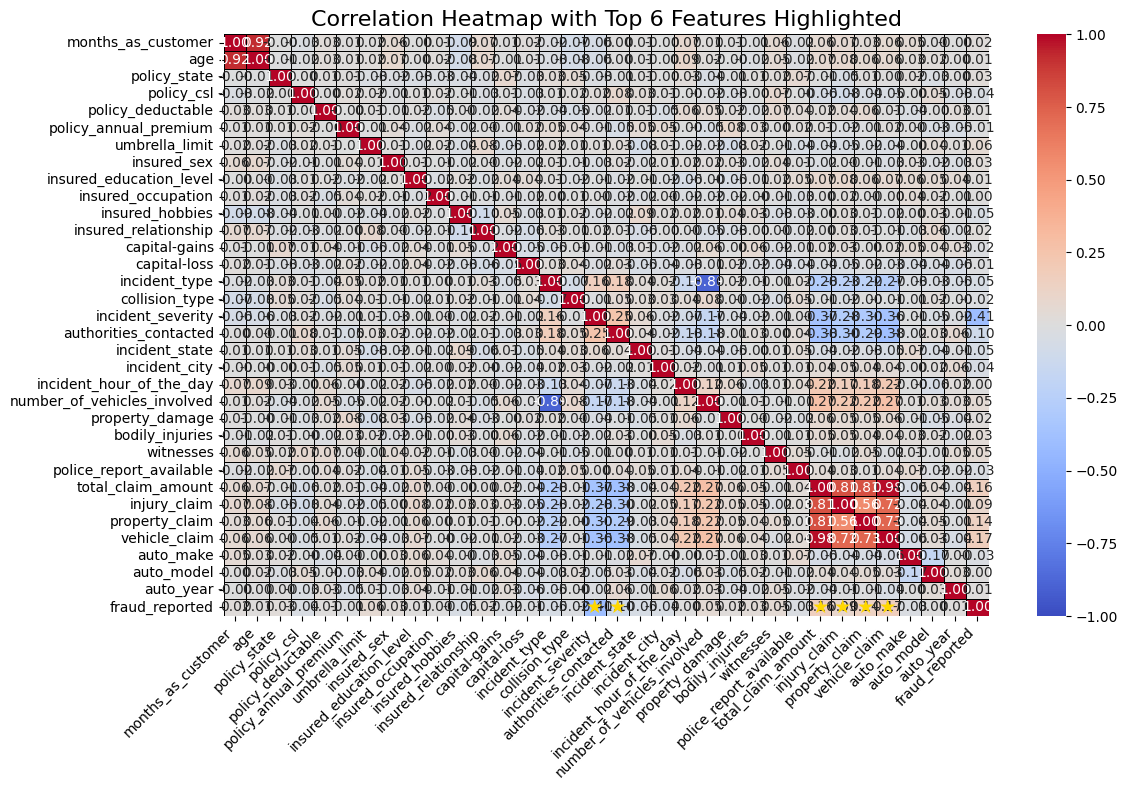

Top 6 features selected: ['incident_severity', 'vehicle_claim', 'total_claim_amount', 'property_claim', 'authorities_contacted', 'injury_claim']

Model Evaluation:
Accuracy: 0.821
ROC-AUC Score: 0.938296
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.82      0.82      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

# Load dataset
insurance_df = pd.read_csv('dataset.csv')

# Drop irrelevant columns
drop_columns = ['policy_number', 'insured_zip', 'incident_location', 'incident_date', 'policy_bind_date']
insurance_df.drop(columns=drop_columns, inplace=True)

# Handle missing values
insurance_df.replace({'?': np.nan}, inplace=True)
insurance_df.fillna(insurance_df.mode().iloc[0], inplace=True)

# Convert categorical variables to numerical using Label Encoding
label_encoders = {}
categorical_columns = insurance_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    insurance_df[col] = le.fit_transform(insurance_df[col].astype(str))  # Convert to string to handle '?'
    label_encoders[col] = le  # Save encoders for later use

# Compute correlations with fraud_reported
correlation_matrix = insurance_df.corr()
top_correlated_features = correlation_matrix['fraud_reported'].abs().sort_values(ascending=False)[1:7]  # Top 6 features
selected_features = top_correlated_features.index.tolist()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Display correlation values in each cell
    fmt=".2f",   # Format values to 2 decimal places
    cmap="coolwarm",  # Color map for the heatmap
    vmin=-1, vmax=1,  # Set the range for correlation values
    linewidths=0.5,   # Add lines between cells
    linecolor="black"  # Color of the lines
)
# Highlight the top 6 features correlated with fraud_reported
plt.title("Correlation Heatmap with Top 6 Features Highlighted", fontsize=16)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Highlight the top 6 features
for feature in top_correlated_features.index:
    plt.text(
        list(correlation_matrix.columns).index(feature) + 0.5,  # X position
        list(correlation_matrix.index).index('fraud_reported') + 0.5,  # Y position
        "★",  # Star symbol to highlight
        ha="center", va="center", color="gold", fontsize=14
    )

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

print("Top 6 features selected:", selected_features)

# Define features and target
X = insurance_df[selected_features]
y = insurance_df['fraud_reported']

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy={1: 5000, 0: 5000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Save the resampled dataset
resampled_df = pd.DataFrame(X_resampled, columns=selected_features)
resampled_df['fraud_reported'] = y_resampled
resampled_df.to_csv('resampled_dataset.csv', index=False)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler and label encoders
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

# Define models
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
svm = SVC(probability=True, kernel='rbf', C=1, random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', rf), ('svm', svm)], voting='soft')
voting_clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(voting_clf, 'voting_classifier_model.pkl')

# Model Evaluation
y_pred = voting_clf.predict(X_test)
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))